# Text Classification with torchtext

`torchtext`에 있는 데이터셋과 `rnn`모델을 이용해서 text classification을 수행

## 1. Text Classification with torchtext

### 데이터 준비

In [ ]:
!pip install torchtext==0.4.0

     |████████████████████████████████| 53 kB 2.2 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.11.0
    Uninstalling torchtext-0.11.0:
      Successfully uninstalled torchtext-0.11.0


In [ ]:
import torch
import torchtext
from torchtext import data
from torchtext import datasets


TEXT = data.Field(tokenize='toktok')
LABEL = data.LabelField(dtype = torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 24.2MB/s]


In [ ]:
print("number of training examples: {}".format(len(train_data)))
print("number of test examples: {}".format(len(test_data)))

number of training examples: 25000
number of test examples: 25000


데이터에 어떤 값이 있는지 확인

In [ ]:
print(vars(train_data.examples[0]))

{'text': ['What', 'network', 'was', ',', 'Diagnosis', 'Murder', 'on', '?', 'I', 'thought', 'it', 'was', 'CBS.', 'Am', 'I', 'right', 'or?', '?', 'Also', ',', 'Back', 'in', 'those', 'days', ',', 'the', 'actual', 'production', 'H.Q.', 'was', 'near', 'about', 'the', 'Van', 'Nuys', 'Airport.', 'I', 'surely', 'remember', ',', 'because', 'I', 'practically', 'made', 'nearly', 'two', 'episodes', 'in', 'those', 'daze.', 'More.', 'I', 'remember', 'the', 'early', 'days.', 'I', 'had', 'found', 'an', 'article', 'in', 'Reader', "'", 's', 'Digest', 'giving', 'this', 'actor/writer', 'a', 'clue', 'to', 'a', 'terrific', 'episode.', 'So', 'just', 'for', 'suggesting', 'it', 'I', 'was', 'awarded.', 'Awarded', 'or', 'not', ',', 'I', 'sadly', 'didn', "'", 't', 'develop', 'it', ',', 'and', 'was', 'cut', 'out', 'of', 'it', 'all', 'due', 'to', 'poor', 'publicity', 'of', 'mine.', 'So', 'as', 'a', 'justification', 'I', 'learned', 'as', 'I', 'always', 'have', ',', 'the', 'hard', 'way', '...', 'Roll', 'the', 'dice',

- IMDB dataset에는 train/test splits만 존재함.
- validation set을 train에서 만들기

In [ ]:
import random
train_data, valid_data = train_data.split(random_state=random.seed(10))

In [ ]:
print("number of training examples: {}".format(len(train_data)))
print("number of validation examples: {}".format(len(valid_data)))
print("number of test examples: {}".format(len(test_data)))

number of training examples: 17500
number of validation examples: 7500
number of test examples: 25000


`vocabulary`를 만든다.
이를 이용하면 효과적으로 `index`를 이용해서 데이터를 표현할 수 있다.

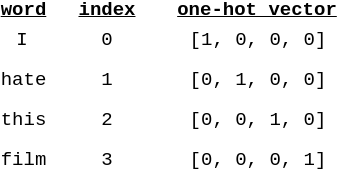

트레이닝셋에서 unique words의 갯수는 100,000개가 넘는다. 이를 one-hot vector로 표현하기 위해서는 100,000 dimension이 넘는 dimension의 vector여야 한다는 뜻이다. 이것은 training을 느리게 만들고 메모리에 올라가지 않을 수 있다.

이 문제를 해결 하기 위해서 1) top $n$ most common words를 이용할수 있는 방법이 있고 2) $m$번 보다 덜 등장하는 모든 words 무시하는 방법이 있을 수 있다.

우리는 1번 방법을 사용할 예정

1번 방법에서 $n$개를 제외한 단어에 대해서는 unknown (\<unk\>) token을 할당해 준다.

예를 들어서, "This film is great and I love it" 문장에서 "love"가 vocabulary에 없다면 문장은 "This film is great and I \<unk\> it"으로 바뀌게 된다.


In [ ]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [ ]:
print("Unique tokens in TEXT vocabulary: {}".format(len(TEXT.vocab)))
print("Unique tokens in LABEL vocabulary: {}".format(len(LABEL.vocab)))

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8777, 'pos': 8723}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Why is the vocab size 25002 and not 25000? One of the addition tokens is the <unk> token and the other is a <pad> token.
`vocabulary` 사이즈가 25000이 아니고 25002인 이유는 \<unk\>와 \<pad\> 때문이다.

Sentence를 모델에 forward 할 때, batch단위로는 모두 데이터 사이즈가 동일 해야 한다. 그래서 batch 안에 있는 sentence의 경우에 짧은 sentence는 padding을 해서 데이터를 생성한다.

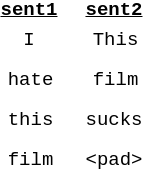

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 203323), (',', 193226), ('and', 109435), ('a', 109177), ('of', 100792), ("'", 94079), ('to', 93617), ('is', 73637), ('/', 71262), ('in', 60732), ('I', 54241), ('it', 50275), ('that', 48777), ('"', 45996), ('s', 43643), ('this', 41567), ('><br', 35539), ('was', 33392), ('as', 30545), ('with', 29638)]


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

### 모델 만들기

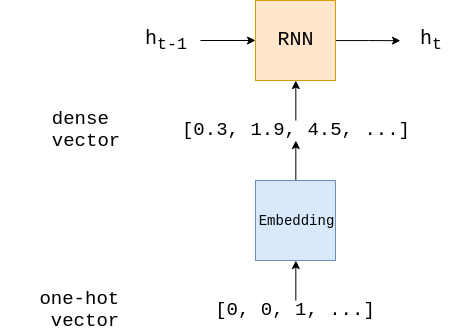

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        #text = [sent len, batch size]

        embedded = self.embedding(text)        
        #embedded = [sent len, batch size, emb dim]
        output, hidden = self.rnn(embedded) 
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1, :,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [ ]:
INPUT_DIM

25002

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,592,105 trainable parameters


### 모델 트레이닝

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    # Train Mode
    model.train()
    
    for batch in iterator:
        
        # Prediction and Loss
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        
        # Optimization Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 15s
	Train Loss: 0.694 | Train Acc: 50.70%
	 Val. Loss: 0.695 |  Val. Acc: 49.83%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.694 | Train Acc: 49.86%
	 Val. Loss: 0.695 |  Val. Acc: 50.87%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.694 | Train Acc: 50.21%
	 Val. Loss: 0.695 |  Val. Acc: 49.49%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.694 | Train Acc: 49.72%
	 Val. Loss: 0.696 |  Val. Acc: 50.94%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 50.09%
	 Val. Loss: 0.698 |  Val. Acc: 51.68%
Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 0.693 | Train Acc: 50.09%
	 Val. Loss: 0.702 |  Val. Acc: 50.75%
Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.692 | Train Acc: 50.50%
	 Val. Loss: 0.713 |  Val. Acc: 49.90%
Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.692 | Train Acc: 50.22%
	 Val. Loss: 0.721 |  Val. Acc: 50.27%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.692 | Train Acc: 50.12%
	 Val. Loss: 0.727 |  Val. Acc: 50.69%
Epoch: 10 | Epoch T

### Advanced Model

In [ ]:
TEXT = data.Field(tokenize = 'toktok', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(10))

In [ ]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.28MB/s]                           
100%|█████████▉| 399999/400000 [00:21<00:00, 18991.39it/s]


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

**Bidirectional RNN**

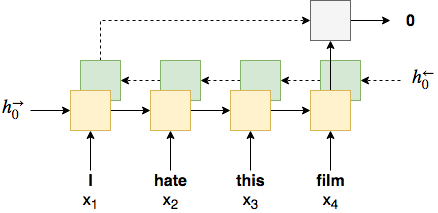

**MUlti-layer RNN**

sentiment4.png

[PackedSequence 관련 설명](https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html)

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

The final hidden state, hidden, has a shape of **[num layers * num directions, batch size, hid dim]**. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, hidden[-2,:,:] and hidden[-1,:,:], and concatenate them together before passing them to the linear layer (after applying dropout).

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.0271,  1.8633,  0.3476,  ..., -0.9630, -0.5483,  0.2244],
        [ 1.9568,  0.4699,  0.5659,  ..., -1.5034,  2.2050, -0.1047],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4034, -0.6402,  0.9244,  ..., -2.2801, -0.1059,  0.8126],
        [ 1.1398, -0.5642,  0.1256,  ..., -0.1482, -0.6340,  0.0992],
        [ 0.2933,  1.4171,  0.7151,  ...,  0.9656,  1.8293,  0.3604]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.4034, -0.6402,  0.9244,  ..., -2.2801, -0.1059,  0.8126],
        [ 1.1398, -0.5642,  0.1256,  ..., -0.1482, -0.6340,  0.0992],
        [ 0.2933,  1.4171,  0.7151,  ...,  0.9656,  1.8293,  0.3604]])


### 모델 트레이닝

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        predictions = model(text, text_lengths.cpu()).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths.cpu()).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 1m 37s
	Train Loss: 0.667 | Train Acc: 58.56%
	 Val. Loss: 0.540 |  Val. Acc: 74.01%
Epoch: 02 | Epoch Time: 1m 38s
	Train Loss: 0.659 | Train Acc: 60.60%
	 Val. Loss: 0.616 |  Val. Acc: 67.01%
Epoch: 03 | Epoch Time: 1m 38s
	Train Loss: 0.622 | Train Acc: 66.20%
	 Val. Loss: 0.515 |  Val. Acc: 76.33%
Epoch: 04 | Epoch Time: 1m 37s
	Train Loss: 0.513 | Train Acc: 75.50%
	 Val. Loss: 0.458 |  Val. Acc: 80.32%
Epoch: 05 | Epoch Time: 1m 37s
	Train Loss: 0.411 | Train Acc: 82.11%
	 Val. Loss: 0.337 |  Val. Acc: 85.88%
Epoch: 06 | Epoch Time: 1m 37s
	Train Loss: 0.326 | Train Acc: 86.62%
	 Val. Loss: 0.318 |  Val. Acc: 87.19%
Epoch: 07 | Epoch Time: 1m 37s
	Train Loss: 0.273 | Train Acc: 88.99%
	 Val. Loss: 0.287 |  Val. Acc: 88.85%
Epoch: 08 | Epoch Time: 1m 37s
	Train Loss: 0.247 | Train Acc: 90.25%
	 Val. Loss: 0.285 |  Val. Acc: 88.55%
Epoch: 09 | Epoch Time: 1m 37s
	Train Loss: 0.216 | Train Acc: 91.64%
	 Val. Loss: 0.285 |  Val. Acc: 89.24%
Epoch: 10 | Epoch T

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.307 | Test Acc: 87.19%


### User Input

In [ ]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
predict_sentiment(model, "This film is terrible")

0.02784966304898262

In [ ]:
predict_sentiment(model, "This film is great")

0.9911139607429504

In [ ]:
predict_sentiment(model, "Type in any words you want")

0.3210245966911316